In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

### Đọc file csv và gắn index với giá Close

In [2]:
df = pd.read_csv('BNB2019-2024.csv')
df1 = df['Close']

#### Chuẩn hóa dữ liệu về khoảng [0, 1].

In [3]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

#### Chia dữ liệu thành tập huấn luyện, kiểm tra và xác thực.

In [4]:
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

print(train_data.shape, test_data.shape, val_data.shape)

(1270, 1) (363, 1) (182, 1)


#### Tạo dữ liệu dạng thời gian (sequence) cho RNN.

In [5]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]      ###i=0, X=0,1,2,3-----99   Y=100    
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

#### Tạo các mẫu dữ liệu thành X=t,t+1,t+2..t+99 and Y=t+100

In [6]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
print (X_train.shape, y_train.shape, X_test.shape, ytest.shape, X_val.shape, yval.shape)

(1169, 100) (1169,) (262, 100) (262,) (81, 100) (81,)


#### Định hình lại dữ liệu để phù hợp với mô hình RNN.

In [7]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

#### Xây dựng mô hình RNN với 50 đơn vị RNN và một lớp đầu ra.

In [8]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.callbacks import ModelCheckpoint

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

### Huấn luyện mô hình trên tập huấn luyện.

In [9]:
model.fit(X_train, y_train, validation_data = (X_test, ytest), epochs=100, batch_size=64,verbose=1)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.2429 - val_loss: 0.0019
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0073 - val_loss: 0.0126
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0021 - val_loss: 6.1881e-04
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0016 - val_loss: 4.1751e-04
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0012 - val_loss: 3.5816e-04
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0013 - val_loss: 4.6199e-04
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0013 - val_loss: 5.1624e-04
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0013 - val_loss: 5.0359e-04
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0012 - val_loss: 2.6783e-04
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0012 - val_loss: 2.4896e-04
Epoch 12/100
19/19 ━

#### Dự báo dữ liệu test, val

In [10]:
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


#### Chuẩn hóa dữ liệu train_predict, y_pred, y_pred_val

In [11]:
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

#### Đánh giá độ chính xác thuật toán bằng RMSE

In [12]:
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 292.7485660135743
Testing RMSE: 290.6713742746447


####  Dự báo 

In [13]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=121
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.30454058 0.30754948 0.3127149  0.32863179 0.32381442 0.31936742
 0.32095245 0.32281328 0.32476162 0.32682432 0.32853373 0.32576097
 0.32810251 0.33368997 0.33201347 0.3422921  0.35259961 0.36807665
 0.35571056 0.35680316 0.36338813 0.36274506 0.36325421 0.35757867
 0.34811602 0.3495097  0.36675674 0.35025292 0.35323429 0.35354256
 0.35599945 0.36657625 0.3258307  0.340314   0.33675585 0.33545785
 0.33776761 0.3341765  0.32723409 0.3306432  0.32711594 0.3276278
 0.32892126 0.33005469 0.32824974 0.3360497  0.33299709 0.33024014
 0.33557263 0.34448539 0.34276336 0.34571182 0.35574894 0.36786681
 0.36475761 0.36643537 0.35346403 0.35264237 0.34507417 0.34813608
 0.36507858 0.37629004 0.39300811 0.39320309 0.3932248  0.38320847
 0.38674482 0.43270004 0.47169776 0.47158018 0.45699175 0.46192565
 0.45482597 0.4577865  0.45432788 0.46116786 0.4715817  0.46235201
 0.44786031 0.4405003  0.44291643 0.43762707 0.44381158 0.44922158
 0.431105   0.43950489 0.43473831 0.46252757 0.4590

#### Trực quan hóa

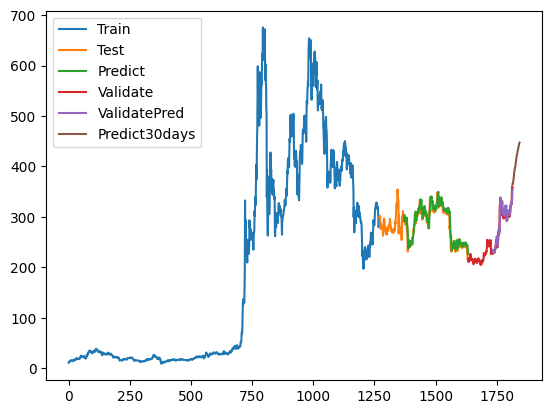

In [14]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()